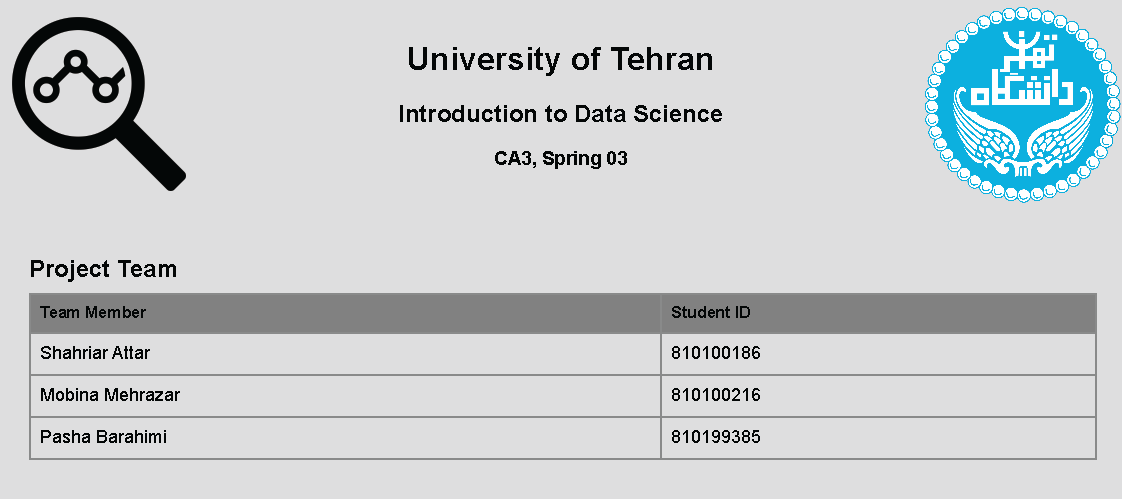


# Spotify Dataset Analysis

## Table of Contents

-   [Spotify Dataset Analysis](#spotify-dataset-analysis)
    -   [Introduction](#introduction)
    -   [Objectives](#objectives)
    -   [Tasks](#tasks)
    -   [Environment Setup](#environment-setup)
    -   [Warm-Up](#warm-up)
    -   [Main Task (Spotify Dataset Analysis)](#main-task-spotify-dataset-analysis)
    -   [Questions](#questions)
    -   [Resources](#resources)

## Introduction

In this assignment, we are going to work with [PySpark](https://spark.apache.org/docs/latest/api/python/index.html), which is the Python API for Apache Spark. It enables us to perform real-time, large-scale data processing in a distributed environment using Python.

## Objectives

The purpose of this assignment is as follows:

1. Learning how to set up PySpark and its requirements.
2. Doing some warm-up exercises, in order to learn how to use PySpark.
3. Using this knowledge to do some investigation on a dataset.

## Tasks

1. **Warm-Up**: In this task, we will do some warm-up exercises to get familiar with PySpark.
2. **Spotify Dataset Analysis**: In this task, we will analyze a dataset containing information about songs and artists from Spotify.


## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.


In [22]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.sql import SparkSession, SQLContext, Row, DataFrame, Window
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler, StringIndexer, PCA
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, abs
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import DenseVector, Vectors, VectorUDT

In [2]:
STOCKS = "../data/stocks.csv"
SPOTIFY = "../data/spotify.parquet"

## Warm-Up

The provided dataset (stocks.csv) contains information about a stock market, with opening, closing, the highest and the lowest price with its volume for each day.


In [3]:
spark: SparkSession = SparkSession.builder.master("local").appName("warm_up").getOrCreate()

In [10]:
def show_df(df: DataFrame) -> None:
    df.show(n=10)
    print(f"Total number of rows: {df.count()}")
    df.printSchema()

1. First, we will read the CSV file.


In [24]:
df: DataFrame = spark.read.csv(STOCKS, header=True, inferSchema=True)

2. Let's find out about the schema of data


In [25]:
df

DataFrame[Date: date, Open: double, High: double, Low: double, Close: double, Volume: int, Adj Close: double]

In [26]:
show_df(df)

+----------+------------------+------------------+------------------+------------------+---------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|
|2010-01-11|212.79999700000002|        213.000002|      

As we can see, the dataset contains the following columns:

-   `Date`: The date of the record.
-   `Open`: The opening price of the stock on that day.
-   `High`: The highest price of the stock on that day.
-   `Low`: The lowest price of the stock on that day.
-   `Close`: The closing price of the stock on that day.
-   `Volume`: The number of stocks traded that day.
-   `Adj Close`: The adjusted closing price of the stock on that day.

The `Adj Close` column is the adjusted closing price of the stock on that day. It is adjusted for stock splits, dividends, and other corporate actions that may have occurred after the date of the record.


In [27]:
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+------------------+
|summary|              Open|              High|               Low|            Close|             Volume|         Adj Close|
+-------+------------------+------------------+------------------+-----------------+-------------------+------------------+
|  count|              1762|              1762|              1762|             1762|               1762|              1762|
|   mean| 313.0763111589103| 315.9112880164581| 309.8282405079457|312.9270656379113|9.422577587968218E7| 75.00174115607275|
| stddev|185.29946803981522|186.89817686485767|183.38391664371008|185.1471036170943|6.020518776592709E7| 28.57492972179906|
|    min|              90.0|         90.699997|         89.470001|        90.279999|           11475900|         24.881912|
|    max|        702.409988|        705.070023|        699.569977|       702.100021|          470249500|127.96609099999999|
+-------

3. Now, we will select the open, close, and volume of the rows with closing price less than 500.


In [28]:
selected_df = df.filter(df["close"] < 500).select("open", "close", "volume")
show_df(selected_df)

+------------------+------------------+---------+
|              open|             close|   volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
+------------------+------------------+---------+
only showing top 10 rows

Total number of rows: 1359
root
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



Let's do that using SQL.


In [29]:
df.createOrReplaceTempView("stocks")  # create a temporary view to use SQL queries


In [30]:
selected_df = spark.sql("SELECT open, close, volume FROM stocks WHERE close < 500")
show_df(selected_df)

+------------------+------------------+---------+
|              open|             close|   volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
+------------------+------------------+---------+
only showing top 10 rows

Total number of rows: 1359
root
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



We can also do that using library functions.


In [31]:
selected_df = F.col("close") < 500
selected_df = df.filter(selected_df).select("open", "close", "volume")
show_df(selected_df)

+------------------+------------------+---------+
|              open|             close|   volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
+------------------+------------------+---------+
only showing top 10 rows

Total number of rows: 1359
root
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



4. Then, we'll find those records with opening price more than 200 and closing price less than 200.


In [32]:
selected_df = (F.col("open") > 200) & (F.col("close") < 200)
selected_df = df.filter(selected_df)
show_df(selected_df)

+----------+------------------+----------+----------+----------+---------+------------------+
|      Date|              Open|      High|       Low|     Close|   Volume|         Adj Close|
+----------+------------------+----------+----------+----------+---------+------------------+
|2010-01-22|206.78000600000001|207.499996|    197.16|    197.75|220441900|         25.620401|
|2010-01-28|        204.930004|205.500004|198.699995|199.289995|293375600|25.819922000000002|
|2010-01-29|        201.079996|202.199995|190.250002|192.060003|311488100|         24.883208|
+----------+------------------+----------+----------+----------+---------+------------------+

Total number of rows: 3
root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



5. Now, let's extract the year from the date column and save it in a new column named `Year`.


In [33]:
df = df.withColumn("Year", F.year("date"))
show_df(df)

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|2010|
|2010-01-11|212.

6. For each year, let's find the minimum volume and show it in a column named `MinVolume`.


In [34]:
min_volume = df.groupBy("Year").agg(F.min("volume").alias("MinVolume"))
show_df(min_volume)

+----+---------+
|Year|MinVolume|
+----+---------+
|2015| 13046400|
|2013| 41888700|
|2014| 14479600|
|2012| 43938300|
|2016| 11475900|
|2010| 39373600|
|2011| 44915500|
+----+---------+

Total number of rows: 7
root
 |-- Year: integer (nullable = true)
 |-- MinVolume: integer (nullable = true)



7. For each year and month, we'll show the highest low price as `MaxLow`.


In [35]:
df = df.withColumn("Month", F.month("date"))
show_df(df)

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+-----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|Month|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+-----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|    1|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|    1|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|    1|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|    1|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700

In [36]:
max_low = df.groupBy("Year", "Month").agg(F.max("low").alias("MaxLow"))
show_df(max_low)

+----+-----+------------------+
|Year|Month|            MaxLow|
+----+-----+------------------+
|2012|   10|        665.550026|
|2010|    7|        260.300003|
|2010|   12|        325.099991|
|2015|    2|        131.169998|
|2014|    4|        589.799988|
|2015|   12|        117.809998|
|2016|    7|            103.68|
|2016|   11|        111.400002|
|2012|    8| 673.5400089999999|
|2013|    2|473.24997699999994|
+----+-----+------------------+
only showing top 10 rows

Total number of rows: 84
root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- MaxLow: double (nullable = true)



8. In the last step, let's calculate mean and standard derivation of high price over the whole data frame and show them in two decimal places.


In [38]:
df_stats = df.select(F.format_number(F.mean("high"), 2).alias("MeanHigh"), F.format_number(F.stddev("high"), 2).alias("StdHigh"))
show_df(df_stats)


+--------+-------+
|MeanHigh|StdHigh|
+--------+-------+
|  315.91| 186.90|
+--------+-------+

Total number of rows: 1
root
 |-- MeanHigh: string (nullable = true)
 |-- StdHigh: string (nullable = true)



## Main Task (Spotify Dataset Analysis)

Now that we've learnt the basics of PySpark, let’s do some investigation on a real dataset! The provided dataset (spotify.parquet) contains information about songs streamed on Spotify, which is an audio streaming and media service provider. We have access to a song’s album, artist, its musical characteristics and its release date.


## Questions

1. **Read about how Spark and Hadoop work. What does the term 'lazy evaluation' mean for them? Explain with a simple example.**

2. **Your main task’s dataset has about 1,200,000 rows, which makes it quite hard, and even sometimes impossible, to work with. Explain how parquet files try to solve this problem, compared to normal file formats like csv.**

3. **As you might have noticed, Spark doesn’t save checkpoints. How can we enforce it to do so? This can help us if we have multiple computation steps and we don’t want to wait a lot for the result.**

4. **Top companies stream their data on a regular routine, e.g. daily. How can we save data, so that we could filter it based on specific columns, e.g. date, faster than regular filtering?**

5. **Let's face off Pandas and PySpark in the data analysis arena! When does each library truly shine, and why? Consider factors like data size, processing complexity, and user experience.**


## Resources

-   [PySpark](https://spark.apache.org/docs/latest/api/python/index.html)
